# CNN with bad image removal and kerasbestfit

**Russ Beuker**

May 27, 2018

<center>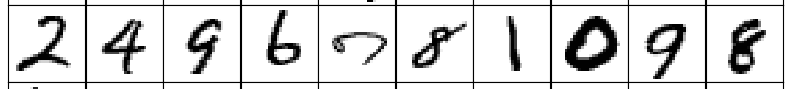</center>
<center>**"two, four, nine, six, uhh.....wtf, eight, one, zero, nine, eight"**</center>
<center>the possible internal dialog of your model while trying to predict these digit labels</center>
<center>and yes, this is actual test data.</center>

Try this notebook if you want to learn about:

- how Kaggle scores your submission. 
- how to load your data faster.
- how to get rid of bad training data.
- how to get the best results by using the new kerasbestfit module.

1. Introduction
     - Model accuracy vs. Kaggle scores
2. Setting up the environment
     - Where to run this code
     - kerasbestfit
3. Preparing the data
     - Goodbye slow .csv.  Hello fast .npy!
     - Removing bad images
     - Exploring class balance
     - Defining the training and validation split
4.  Training the model
    - Defining the model
    - Using kerasbestfit
    - Analysing the results
    - Reviewing the confusion matrix
7.  Predictions    
    - Testing against a known dataset
    - Predicting the Kaggle test data
    - Creating the submission.csv
8.  Conclusion
    - Finding kerasbestfit on GitHub
    - The Kaggle digit png's
    - A brief test



# Introduction

This notebook shows how to design and train an efficient Convolutional Neural Network (CNN) on the Kaggle Digit Recognizer dataset.  I wrote this in Python 3.6 with Keras using the Tensorflow backend as it provides a quick and easy prototyping environment with acceptable performance.

**Model accuracy vs. Kaggle scores**

Should you care if you get a good Kaggle score?  Yes, but only to a point.  This particular competition is more about exploring how machine learning works.  It will give you a good base of knowledge to tackle the other competitions.  Read the discussions.  Learn.  It's all good.

While training this model, you will see final validation accuracy (val_acc) between 99.70 and 99.80.  This is the accuracy of the model as evaluated against the validation dataset.  This kernel will create a submission.csv which you can optionally submit to the competition to see how your results rank on the leaderboard.  However, you will likely see lower Kaggle scores than your val_acc score (99.3 to 99.6).

Here is how Kaggle will score your results (https://www.kaggle.com/c/digit-recognizer/data): 

* *"The evaluation metric for this contest is the categorization accuracy, or the proportion of test images that are correctly classified. For example, a categorization accuracy of 0.97 indicates that you have correctly classified all but 3% of the images."* *

and from the Leaderboard (https://www.kaggle.com/c/digit-recognizer/leaderboard):

* *"This leaderboard is calculated with approximately 25% of the test data. The final results will be based on the other 75%, so the final standings may be different."* *

When you submit your submission.csv to Kaggle for scoring, you are only being scored a small part of the total test dataset.  So if your submission.csv has 28000 predictions, Kaggle will score based on 28000*0.25 = 7000 of those.  We don't know which 25% it selects, but I have experimented with this by submitting the same .csv immediately twice and received the same Kaggle score so it doesn't appear to be a random selection, at least in this instance.  Maybe the selection is different per user, or has a different random selection seed per person, or the seed changes per day.  It remains a mystery.

It could be that the 25% of your predictions selected for your score, just by luck, are very good predictions and totally missed the bad predictions elsewhere in the file.  Your Kaggle score would be high, but at the end of the competition the score would be calculated with all 28000 predictions and would appear lower.

So how to get a high Kaggle score?  Train a good model that you know gives a good val_acc as well as a good prediction based on the Keras built-in MNIST dataset.  If that looks good, submit your submission.csv to Kaggle and check out your score.  Be happy.  Be sad.  It doesn't matter until early 2020 when the final scores are calculated.  Expect the leaderboard to change a lot when that happens.  But if you have submitted a solid set of predictions based on a great model, your new score will be good too.

# Setting up the environment

**Where to run this code**

You can run this notebook on Kaggle, but there are time limits (6 hours as of publication date) which restrict how long you can train your model to find the best accuracy.  Some tips and tricks:
1.  Use the kerasbestfit timer function so that the training will run for, say, 5 hours and 45 minutes before predicting and saving the submission.csv file.
2.  Copy this notebook and run it on your own hardware or on the cloud.
3.  Grab the **full Python script over here on Github** and run it outside the notebook environment on the hardware of your choice.

In developing this code and in experimenting with neural networks, I use my dev PC which has a good GPU, so I can iterate a lot of ideas quickly.  For running on CPU, you will probably need to reduce the batch size from 500.

Here are the imports.  All these modules are included with the standard Kaggle kernel, except one:

**kerasbestfit**

This is a Python module that I wrote to make finding the best model easier.  The module uses Keras's EarlyStopping and Checkpoint callbacks so that you just need to call one function and it finds and saves the model that has the best metrics.  

The advantage to using this module is that you can just let it run and you'll find the best model in your folder where you can later use it for predictions.  It can also stop after a certain duration so that you can fit the training session into Kaggle's 6 hour limit. There is even a snifftest parameter where you can skip training an iteration that has very poor performance, thus saving training time.

Why did I create a new module instead of using Sklearn, T-Pot or something else to find the best fit?  Because it made me dig into Keras to understand it better.  Simple as that.  The result is a pretty nifty function.

You can find the source code over at my GitHub here.

**Installing kerasbestfit**

If you want to experiment with this Kernel, just Fork it and you'll get your own copy with kerasbestfit already installed.

If you want to use kerasbestfit with a brand new kernel, you will need to install the module.  Fortunately, Kaggle makes this easy to do.  Just create a new kernel and go to the kernel Settings tab and scroll to the bottom. You'll find a place to Add a custom package like this:

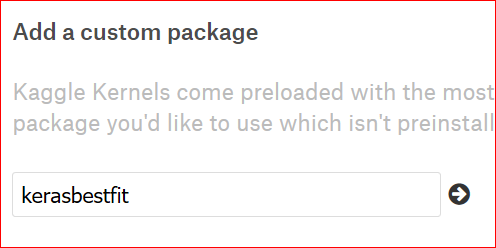 
 
<center>Type in kerasbestfit and press the Enter key.</center>



<center>A successful install will look like the following:</center>

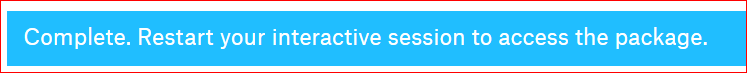



<center>You'll need to restart your kernel, so click on the button shown below.</center>

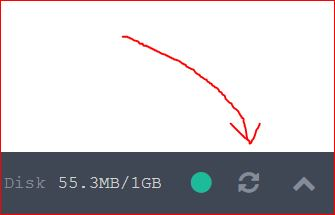    


In [1]:
# hide harmless Python warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
from datetime import datetime, timedelta
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Dense, Dropout, MaxPooling2D, Flatten, Activation, Input
from keras.layers.convolutional import Conv2D
from keras.models import Model, model_from_json
from keras import backend as K
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

from kerasbestfit import kbf  # read the above info on how to install this custom module.

# prevent Tensorflow from displaying harmless warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# set numpy to be able to display wider output without truncating
np.set_printoptions(suppress=True, linewidth=np.nan, threshold=np.nan)

# set the paths and filenames
train_file_csv = ".//input//train.csv"
test_file_csv = ".//input//test.csv"
x_train_file_npy = ".//input//x_train.npy"
y_train_file_npy = ".//input//y_train.npy"
x_test_file_npy = ".//input//x_test.npy"
x_train_cleaned_file_npy = ".//input//x_train_cleaned.npy"
y_train_cleaned_file_npy = ".//input//y_train_cleaned.npy"
model_path = ""

# define a logger function.  This will log to the screen and/or file.
# we'll also pass this function as a parameter to the kerasbestfit function later
log_file = ".//log.txt"
log_mode = 'both'
def log_msg(msg=''):
    fmt = "%H:%M:%S"
    s = f'{datetime.today().strftime(fmt)}: {msg}'
    if log_mode == 'file_only' or log_mode == 'both':
        with open(log_file, "a") as myfile:
            myfile.write(f'{s}\n')
    if log_mode == 'screen_only' or log_mode == 'both':
        print(s)

Using TensorFlow backend.


# Preparing the data

### Goodbye slow .csv. Hello fast .npy!

Kaggle provides the data as training.csv and test.csv files, which is great because csv is easy to read.  But it is also bad because it takes forever (seconds) to load.  If you are tweaking the code a lot you don't want to waste all that time with loading data every time you run your kernel.

So we'll speed it up by loading the csv files once, converting the data to a numpy arrays, and then saving the arrays as x_train.npy. y_train.npy and x_test.npy.  We won't use those .csv files again.

In [2]:
# convert the kaggle input data csv's to faster .npy. Keep the data types as uint8 so the files are small as possible
convert_csv_to_npy = False  # set this to False so you don't have to run it again
if convert_csv_to_npy:
    # convert the train.csv
    # the train.csv file has the first columns for the label and the remaining columns as pixel data.  
    # we'll use this data for training the model.
    mnist_train_dataset = read_csv(train_file_csv, delimiter=',').values
    # extract the first column.  This will be the labels and we'll call it y_train
    y_train = mnist_train_dataset[:, 0]
    y_train = y_train.astype('uint8')
    # extract the remaining columns. This will be images we'll call it x_train
    x_train = mnist_train_dataset[0:, 1:]
    x_train = x_train.astype('uint8')
    
    # convert the test.csv.  This file contains images only. It doesn't contain labels.  This data will be used
    # later on when we test the model for creating the submission.csv we'll send to Kaggle for scoring.
    mnist_test_dataset = read_csv(test_file_csv, delimiter=',').values
    x_test = mnist_test_dataset
    x_test = x_test.astype('uint8')
    np.save(x_train_file_npy, x_train)
    np.save(y_train_file_npy, y_train)
    np.save(x_test_file_npy, x_test)
    
    # we now have x_train.npy and y_train.npy for training, and x_test.npy for testing.  

In [3]:
# now let's load the training data from those fast .npy files.  Note how fast it loads!
x_train = np.load(file=x_train_file_npy)
y_train = np.load(file=y_train_file_npy)
# we will load the x_test file later, just before we need to do a prediction using our model
# print out the array dimensions so we can see how much data we have
log_msg(f'x_train: {x_train.shape}.  These are the training images.')
log_msg(f'y_train: {y_train.shape}.  These are the training labels.')

16:11:46: x_train: (42000, 784).  These are the training images.
16:11:46: y_train: (42000,).  These are the training labels.


### Removing bad images

We can see from the above cell results that we have a training dataset containing 42000 test images and 42000 test labels.  But we can't assume that the dataset is pristine and correct. We need to review it and get a feel for the data and ensure that it is valid and doesn't contain any errors.  But how do we review the training data?

Let's take a look at one of the images in x_train. In this example, we'll look at the image at index position 8. It's looks like it is a five.  Try changing it from an 8 to any other index from 0-41999 and explore the data.

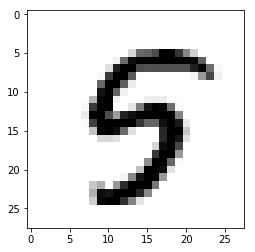

In [4]:
plt.imshow(x_train[8].reshape([28, 28]), cmap=plt.get_cmap('gray_r'))
plt.show()

It would take a too long to look at each image, but luckily we have a set of image files that contain all 42000 digits for your review.  I created a script that generates a .png file with all the zero's, then another file with all the one's, etc.  There are approximately 4200 digits per file.  Then you just need to load up these .png's in an image viewer util and start reviewing the images.  It took me about five hours to look through the images and mark the digits that I thought were wrong, or would at least mislead the model.  It was a mind-numbing experience.

One thing I did find out was that the images used in this competition are not the same as found in the original MNIST dataset.  It looks like the Kaggle images are augmented MNIST images - meaning that they have had rotations, scaling and transforms applied to the original images.  This has implications on whether you should do your own augmentation on the training dataset, since they have already been augmented.  The test images looks the same, so we are dealing with pre-augmented images with a wide variation of tweaks.  Because of this, I chose to not augment the images any further.

You can find the script and png files over at my GitHub over here.

I identified each bad image by the array index number. Here is an example of the digit 8.  It could look 4-ish and could lead to confusion as to what an 8 actually looks like.  I think the augmentation messed up this digit so that it is not longer clearly recognizable, so we'll call this a bad image and remove it from our training dataset.

Feel free to change it from index 35396 to any other index found in the bad image list below to see what we are going to exclude.  

Try 28851, which it also supposed to be an 8.  No.  Just No.

The end result of removing these bad images is the model will more accurately know what an 8, and other digits should look like.  If you run the kerasbestfit function by using val_loss as the metric, you will see the loss being quite a bit lower by using the dataset without the bad images.  Interestingly, this really doesn't improve the accuracy much since it is already pretty high.  But it is good to know that if the model predicts an 8 incorrectly, it won't because we fed the model bad data.  As always, the old rule 'Garbage in, garbage out' applies.

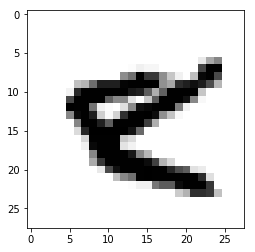

In [5]:
# let's take a look at some of these bad images
plt.imshow(x_train[35396].reshape([28, 28]), cmap=plt.get_cmap('gray_r'))
plt.show()

In [6]:
# remove incorrect images from our training data set
lst = [12817,  # 0's
       60, 191, 2284, 2316, 5275, 7389, 19633, 19979, 24891, 29296, 32565, 38191, 38544, 40339, 41739,  # 1's
       4677, 7527, 9162, 13471, 16598, 20891, 27364,  # 2's
       240, 11593, 11896, 17966, 25708, 28560, 33198, 34477, 36018, 41492,  # 3's
       1383, 6781, 22478, 23604, 26171, 26182, 26411, 18593, 34862, 36051, 36241, 36830, 37544,  # 4's
       456, 2867, 2872, 5695, 6697, 9195, 18319, 19364, 27034, 29253, 35620,  # 5's
       7610, 12388, 12560, 14659, 15219, 18283, 24122, 31649, 40214, 40358, 40653,  # 6's
       6295, 7396, 15284, 19880, 20089, 21423, 25233, 26366, 26932, 27422, 31741,  # 7's
       8566, 10920, 23489, 25069, 28003, 28851, 30352, 30362, 35396, 36984, 39990, 40675, 40868, 41229,  # 8's
       631, 4226, 9943, 14914, 15065, 17300, 18316, 19399, 20003, 20018, 23135, 23732, 29524, 33641, 40881, 41354  # 9's
       ]
x_cleaned = np.delete(x_train, lst, 0)
y_cleaned = np.delete(y_train, lst, 0)
np.save(x_train_cleaned_file_npy, x_cleaned)
np.save(y_train_cleaned_file_npy, y_cleaned)

We now have removed the bad images and have the x_train_cleaned.npy and y_train_cleaned.npy files and will use these two new .npy files for training.

**Summary so far**

We made data loading faster and cleaned out the bad data.  Next up, class balance.

### Exploring class balance

We need to examine our training data to make sure we have enough of each digit for training to be successful.  A good class balance would have an identical number of zeros, ones, two's etc.  

Let's load up our clean data and see what our training data has for class balance:

In [7]:
# reload the clean data from those fast .npy files
x_train = np.load(file=x_train_cleaned_file_npy)
y_train = np.load(file=y_train_cleaned_file_npy)
# count the number of training and test images
log_msg(f'There are {x_train.shape[0]} training images.')

16:11:49: There are 41891 training images.


Note that there are now only 41891 training images, so we removed 109, or 0.00259%.  When we are tuning our model to get an extra 0.001 percent accuracy, this is significant.

16:11:50: Class balance:
[[   0    1    2    3    4    5    6    7    8    9]
 [4131 4667 4170 4342 4060 3785 4127 4390 4049 4170]]


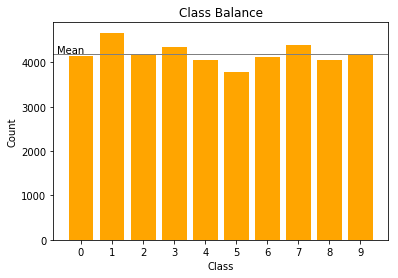

In [8]:
# calculate class balance
log_msg('Class balance:')
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)))

# plot a barchart showing class balance and mean count
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Class Balance')
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.annotate("Mean", xy=(0.012, 0.86), xycoords="axes fraction")
plt.xticks(unique, unique)
ax.axhline(counts.mean(), color='gray', linewidth=1)
ax.bar(unique, counts, color='orange', align="center")
plt.show()

We can see that the class balance is fairly even.  The digit 5 has the lowest number of images which could could cause problems when trying to tell it apart from the digit 6, which can look similar.  So our intuition tells us we could have problems with 5's.

Solutions for this problem could be that we further reduce the number of certain images so that all digits have the same number of images.  But that feels wrong that we would be throwing away data.  Instead, we'll use a technique called Stratification when we carve off part of this dataset as the validation dataset.  Confused? Read on.

### Defining the training and validation split

We require two sets of images for training our model: Training and Validation.  The Validation dataset will have a small amount of images that will be used by the .fit function to monitor the training progress.

You may ask why we just don't use the test dataset for this. The reason we don't is that we do not want to introduce any bias into the .fit function - we don't want it to see the final images that it will be tested on.  This is a general machine learning rule, though the Keras .fit function, which is called by our kerasbestfit function, can lead to a bit of confusion since their examples talk about using test data as validation data.  There is a lively discussion about this over at https://github.com/keras-team/keras/issues/1753

So we'll avoid this issue by only using our test data when it is time to create the final predictions for the submission.csv file.  It means carving off 10% of our training data for validation, but this seems to work out fine.

In the following code, we'll take a look at the shape of the arrays holding our training data, then split it into separate train and validation datasets.

In [9]:
# let's take a look at the training data shape and format
log_msg(f'x_train shape is {x_train.shape} of data type {x_train.dtype}.  These are our training IMAGES.')
log_msg(f'y_train shape is {y_train.shape} of data type {y_train.dtype}.  These are our training LABELS.')

16:11:51: x_train shape is (41891, 784) of data type uint8.  These are our training IMAGES.
16:11:51: y_train shape is (41891,) of data type uint8.  These are our training LABELS.


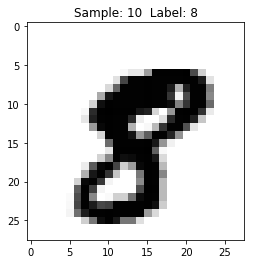

In [10]:
# let's examine one of the training images. We'll pick the eleventh image in the array
# this is a snifftest to ensure that our clean dataset actually has valid data
sample = 10  # change this value to see different images
plt.title('Sample: %d  Label: %d' % (sample, y_train[sample]))
plt.imshow(x_train[sample].reshape([28, 28]), cmap=plt.get_cmap('gray_r'))
plt.show()

In [11]:
# now let's split up our training data into TRAINING and VALIDATION datasets.
# the random seed ensures thta we get the same identical data split every time we run this function.
# you can also run this without a random seed to let it randomly split the data.
# The stratify parameter tells it to make the class balance ratios the same in the training and validation datasets.
# this avoids the situation of a digit becoming over/underrepresented in either dataset.
# for example, if 5's were only 8% of the training data, we sure don't want the validation dataset to only 
# have 3% of fives.  Stratify will keep it at 8%.
random_seed = np.random.seed(2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=random_seed,
                                          stratify=y_train) 

We now have the following datasets:
     - x_train: training images
     - y_train: training labels 
     - x_val: validation images
     - y_val: validation labels   
     
The model requires the training data in a certain format, so we'll:

- change the image data type to float32 and normalize the image data.  This takes us from pixel value range of (0 - 255) down to (0.0 - 1.0).
- reshape the image arrays to from a string of 784 pixels to a grid of 28x28 pixels.
- change the label data type to float32 and change it to 'one-hot' format.


In [12]:
log_msg('')
log_msg('Changing data type to float and normalizing values...')
# we'll need change our data type to float and normalize the image data
# set datatypes to float32 and normalize
x_train = x_train.astype('float32')
x_train /= 255
x_val = x_val.astype('float32')
x_val /= 255
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
log_msg(f'x_train shape is {x_train.shape} of data type {x_train.dtype}.  These are our TRAINING images.')
log_msg(f'x_val shape is {x_val.shape} of data type {x_val.dtype}.  These are our VALIDATION images.')

# and we'll also need to convert our y_train labels float32 to one-hot encoding
y_train = np_utils.to_categorical(y_train, 10)
y_train = y_train.astype('float32')
y_val = np_utils.to_categorical(y_val, 10)
y_val = y_val.astype('float32')
log_msg(f'y_train shape is {y_train.shape} of data type {y_train.dtype}.  These are our TRAINING labels.')
log_msg(f'y_val shape is {y_val.shape} of data type {y_val.dtype}.  These are our VALIDATION labels.')

16:11:55: 
16:11:55: Changing data type to float and normalizing values...
16:11:55: x_train shape is (37701, 28, 28, 1) of data type float32.  These are our TRAINING images.
16:11:55: x_val shape is (4190, 28, 28, 1) of data type float32.  These are our VALIDATION images.
16:11:55: y_train shape is (37701, 10) of data type float32.  These are our TRAINING labels.
16:11:55: y_val shape is (4190, 10) of data type float32.  These are our VALIDATION labels.


### Summary so far

We have imported our data and prepared it for training.

# Training the Model

Finally we have a good set of training data all ready to go.  Let's train our CNN model and try to get the highest metric value, which in this example, is val_acc, or 'validation accuracy'.

### Defining the model
I have provided a pretty good CNN model for this example, but you can modify this model to see how various parts of it work.  For example, yo ucould change the Dropout to 0.9 and then run the following code to see how accurate the model would be.  Fee free to change anything and experiment.

This model is based on a simple CNN model and then I tested/tweaked it until I found that this one worked quite well.  There are many, many ways to build a model, so this will get you started.

The model is also built using the Keras Functional API instead of Sequential mode.  This gives you much more flexibility when creating models with unique features.  If you are just starting out, I would recommend using the functional API for all your models because eventually, advanced models will require it.

    
### Using kerasbestfit
The kerasbestfit module is a wrapper around the Keras .fit function with earlystopping and checkpoint callbacks already implemented. It has ability to save the best model weights and stop training after a certain number of iterations or time limit.  In the example below, you can set the following:

- epochs: the number of times per iteration that the entire training and validation datasets are used to optimize the model.
- batch_size: the number of images to send through the model at a time before backpropagation occurs. 
- patience: when the iteration finds a new best metric value, it will continue to looks for an even better value for the 'patience' epochs.  So if it found a great metric value at epoch 20, and your patience is 5, it will continue looking for an even better metric value until epoch 25, after which it will go to the next iteration if hasn't found one.  Confused?  Watch the * in the outputs to see when it has found the best metric value in the current iteration.
- snifftest_max_epoch, snifftest_metric_val=0: this tests to see whether the snifftest_metric_val has been found by
  snifftest_max_epoch. If it hasn't, it will abort the iteration and move on to the next iteration.  This is handy
  in hyperparameter searches where you just don't want to continue with the current iteration if it has horrible
  results, like ex. hasn't reached val_acc of 0.5 after 5 epochs.  This saves a lot of unnessary training on bad
  parameter combinations.
- finish_by: the maximum minutes that the training should run for. You could check the time outside the training
  loop, but this will actually check after each epoch, way up in the checkpoint callback, so it is better.
- save_path: the path in which the model.hdf5 and model.json files will be saved.
 
#### Sample output

Here is an example of a single iteration with 2 epochs

20:48:30:   e0: val_acc=0.9544152724 *  bsf=0.9739856886 

20:48:33:   e1: val_acc=0.9801909278 *! bsf=0.9801909278  Saved 

Let's look at the second line:

    20:48:30                the time
    e0                      the current epcoh
    val_acc=0.9544152724    the metric and metric value found at this epoch
    *                       the asterisk means that this metric value is the best so far for this iteration
    !                       the exclamation means that this metric value is the best so far across all iterations.
    bsf=0.9739856886        this is the best metrical val so far across all iterations.
    saved                   the model weights were saved on this epoch
    snifftest_fail          the snifftest has not been passed and this iteration is being aborted
    
A typical training run will see lots of Saved messages, but these will become less frequent as training progresses because it remembers the best results so fare across all iterations.   
    
### What happens if training is interrupted?

It can happen.  Browser crash, kernel crash, sometimes we never do know why.  If training is interrupted, the best results found so far have already been saved in the model.json and model.hdf5 files, so you could just set the do_training = False to bypass training again and go straight to the prediction code.
    
### Tips for best results

- Run a low number of iterations such as x=2, but increase epochs to 200 and patience=20.  This gives better results than doing higher number of iterations like x=2, epoch 10, patience 5.  Try even higher epochs and patience to wring out the best result possible for the model.
- Tweak the model or make your own.  You could add, remove or modify layers.  Try changing the dropout value from 0.5 to 0.9 and see how it affects the results.
- Let it run.  The very best results take time for the training to find it.  Run it overnight, for a day, etc and see what happens.
- Try tweaking the train/validation split in the code above from 10% to maybe 15%.  See if this makes a difference.  If you change any of the code above, don't forget to re-run all the code right up to the training block so that all the data is reloaded.  See, those fast .npy's really are useful after all.
- Try changing the metric to 'val_loss' instead of 'val_acc'.  This may give you additional insights on how well the model is performing. 

In [18]:
do_training = True  #set this to False if you want to skip training and go straight to prediction
if do_training:
    log_msg('---- TRAINING BEGIN ----')        
    # this is for formatting numbers in the log
    format_metric_val = '{:1.10f}'  

    # set this to val_acc for accuracy, and val_loss for loss.  Running val_loss is fine for this competition.
    metric = 'val_acc'              
    if metric == 'val_acc':
        best_metric_val_so_far = 0
        snifftest_max_epoch = 0
        snifftest_metric_val = 0
    elif metric == 'val_loss':
        best_metric_val_so_far = 100.0
        snifftest_max_epoch = 0
        snifftest_metric_val = 100.0
        
    iter_best_fit = 0
    # init timed session.  This allows you to set a training time limit.  Handy for Keras 6 hour limit.
    max_duration_mins = 60  # this is 60 minutes.  Set it to 0 if you don't want a timed session.
    fmt = "%a %b %d %H:%M:%S"
    if max_duration_mins == 0:
        started_at = 0
        finish_by = 0
    else:
        started_at = datetime.today()
        finish_by = started_at + timedelta(minutes=max_duration_mins)
        log_msg(f'Started at {started_at.strftime(fmt)}, finish by {finish_by.strftime(fmt)}')

    # run the training x times and save the model weights that give the best metric
    # you could set it to x = 200 and let it run for hours if you want.
    # note: you can't pause training, then resume it later due to the nature of the Adam optimizer,
    # so you must train it uninterrupted.
    # training will end after the max_duration_mins has passed or x iterations has completed, whichever happens first.
    x = 1
    epochs=2
    patience=3
    batch_size=500
    for xtr in range(0, x):
        K.clear_session()  #clears tensorflow resources
        log_msg(f'Iteration {xtr} of {x - 1}')
        # now we'll define our model.  
        input = Input(shape=(28, 28, 1))
        x1 = Conv2D(32, (5, 5), padding='same', kernel_initializer='he_normal')(input)
        x1 = Activation('relu')(x1)
        x1 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x1)
        x1 = Activation('relu')(x1)
        x1 = MaxPooling2D(pool_size=(2, 2))(x1)
        x1 = Dropout(0.5)(x1)
        x1 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x1)
        x1 = Activation('relu')(x1)
        x1 = Conv2D(32, (5, 5), padding='same', kernel_initializer='he_normal')(x1)
        x1 = Activation('relu')(x1)
        x1 = Dropout(0.5)(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x1)
        x1 = Dropout(0.5)(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu', kernel_initializer='he_normal')(x1)
        x1 = Dropout(0.5)(x1)
        output = Dense(10, activation='softmax', kernel_initializer='he_normal')(x1)
        model = Model(inputs=[input], outputs=[output])
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        #call the kerasbestfit.find_best_fit function.  It will save the model weights with the best metric
        results, log = kbf.find_best_fit(model=model, metric=metric, xtrain=x_train, ytrain=y_train, xval=x_val,
                                         yval=y_val, validation_split=0, batch_size=batch_size, epochs=epochs, 
                                         patience=patience, snifftest_max_epoch=snifftest_max_epoch,
                                         snifftest_metric_val=snifftest_metric_val,
                                         show_progress=True, format_metric_val=format_metric_val,
                                         save_best=True, save_path=model_path,
                                         best_metric_val_so_far=best_metric_val_so_far)
        
#                                          logmsg_callback=log_msg, finish_by=finish_by)
        del model
        # notify if we found a new best metric val
        is_best = False
        if metric == 'val_acc':
            is_best = results['best_metric_val'] > best_metric_val_so_far
        elif metric == 'val_loss':
            is_best = results['best_metric_val'] < best_metric_val_so_far
        if is_best:
            iter_best_fit = xtr
            best_metric_val_so_far = results['best_metric_val']
            sbest_metric_val_so_far = metric + '=' + format_metric_val.format(best_metric_val_so_far)
            sbest_epoch = results['best_epoch']
            best_log=results['history']
            best_epoch=results['best_epoch']
            s = f'NEW BEST SO FAR: {sbest_metric_val_so_far} on epoch {sbest_epoch}\n'
            log_msg(s)

        if results['expired']:
            break

    log_msg(f'The best result is {sbest_metric_val_so_far}')        
    log_msg('---- TRAINING END ----')        

20:22:18: ---- TRAINING BEGIN ----
20:22:18: Started at Sun May 27 20:22:18, finish by Sun May 27 21:22:18
20:22:19: Iteration 0 of 0
20:22:25: NEW BEST SO FAR: val_acc=0.9723150417 on epoch 1

20:22:25: The best result is val_acc=0.9723150417
20:22:25: ---- TRAINING END ----


### Analysing the results

Let's plot the accuracy and loss curves for our best result.  Learning how to interpret these graphs will help you avoid results that suffer from overfitting or underfitting.  The perfect plot would be one where the two lines for the metric you chose (for example, val_acc uses the acc and val_acc lines) would be right on top of each other.

The vertical dotted line represents the epoch in which the best result was found and saved.  The area to the right of the vertical line represents the patience epochs, where it waits for an even better result, but finds none.

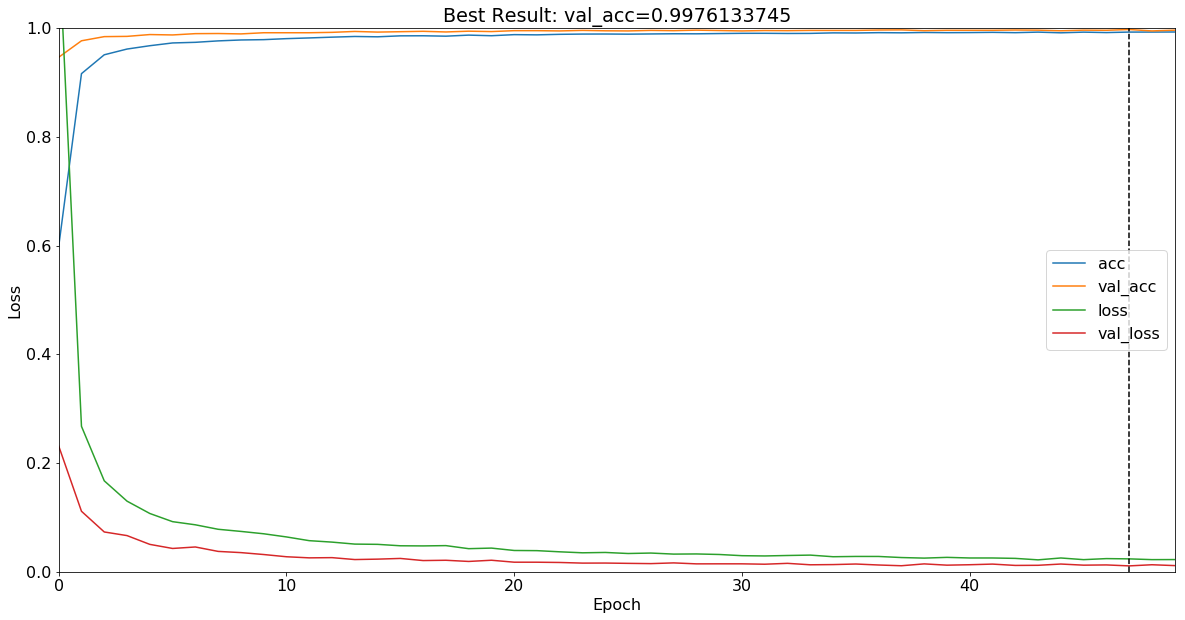

In [230]:
# generate plot or accuracy and loss
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(20,10))
plt.xlim(0.0, best_epoch + 2.0)
plt.ylim(0.0, 1.0)
plt.plot(best_log['acc'])
plt.plot(best_log['val_acc'])
plt.plot(best_log['loss'])
plt.plot(best_log['val_loss'])
plt.axvline(results['best_epoch'], 0, 1, color='k', linestyle='--')
plt.title(f'Best Result: {sbest_metric_val_so_far}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['acc', 'val_acc', 'loss', 'val_loss'], loc='center right')
plt.show()

### Review the confusion matrix

Using a confusion matrix allows you to see exactly which errors occurred with the validation data.  Let's load the saved model and do a prediction with the validation data.

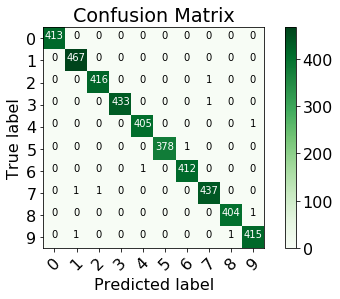

In [231]:
# load saved model
with open('.//model.json', 'r') as f:
    modelx = model_from_json(f.read())
modelx.load_weights('.//model.hdf5')
Y_pred = modelx.predict(x_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_val, axis=1)

# this confusion matrix code from: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
cm = confusion_matrix(Y_true, Y_pred_classes)
classes = range(10)
normalize = False
cmap = plt.cm.Greens
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix')
plt.colorbar()
plt.rcParams.update({'font.size': 10})
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    # val = cm[i, j]
    # val = 100.0 * val/cm[i, :].sum()
    # print(cm[i, j], val)
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
del modelx

# Predictions

We'll try making a prediction with our model and data that the model has never seen before, so let's load our saved model.

In [232]:
# load test data
x_test = np.load(file=x_test_file_npy)
x_test = x_test.astype('float32')
x_test /= 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
y_test = None  # we don't have this data because we don't have the test labels available

# load saved model
with open('.//model.json', 'r') as f:
    modelx = model_from_json(f.read())
modelx.load_weights('.//model.hdf5')


### Testing against a known dataset

Let's run the prediction against the Keras built-in MNIST dataset.  This gives us a bit of a sanity check.  The prediction accuracy should be similar to the val_acc determined during training.

In [233]:
# try the model with the built-in Keras MNIST dataset
log_msg('')
log_msg('Trying the model with the Keras built-in MNIST test dataset...')
(x_keras_train, y_keras_train), (x_keras_test, y_keras_test) = mnist.load_data()
x_keras_test = x_keras_test.astype('float32')
y_keras_test = y_keras_test.astype('float32')
x_keras_test /= 255
x_keras_test = x_keras_test.reshape(x_keras_test.shape[0], 28, 28, 1)
# y_keras_test = np_utils.to_categorical(y_keras_test, 10)
test_labels = modelx.predict(x_keras_test)
predicted_classes = np.argmax(test_labels, axis=1)
correct_indices = np.nonzero(predicted_classes == y_keras_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_keras_test)[0]
accuracy = len(correct_indices) / (len(correct_indices) + len(incorrect_indices))
log_msg(f'Prediction is {accuracy}')


11:06:37: 
11:06:37: Trying the model with the Keras built-in MNIST test dataset...
11:06:38: Prediction is 0.9978


### Predicting  the Kaggle test data

Finally, all this effort is about to pay off!  Let's try predicting just a single digit from the Kaggle test dataset. This is the dataset on which our submission.csv will be based on.

#### First, try a single image

Let's try to predict the image at index position zero.  It will display the digit, and then the class probabilities.    

The class probabilities are a list of ten floating point values.  Find the highest value.  You'll notice it is the third number, which is index 2 in the probability list.  The predicted digit is therefore a 2.  

If one of the class probabilities is very high and the rest are very low, then the model is very confident of the result.  But if you have a result where there isn't an obvious highest value, the model isn't as confident.  If the model is perfectly confident, the class probablilty for one of the numbers would be 1.0.  if it was perfectly unconfident, all probablities would be 0.10.  Confused yet?  Try running the class probabilities for many different images to get a feel for how this works.

In the code below, try changing the index to 12.  The resulting image is confusing.  Is it a 4?  Or is it a 7? 

Also try index 2009. Is it a 1 or 2?  What do the probablities say?

The model predicts it is a 4, but we don't know if this is correct.  Only Kaggle knows if it is correct.

11:16:52: Predicting a single test image...


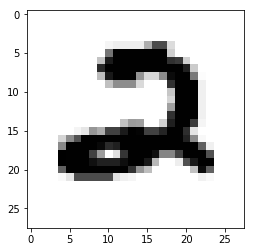

11:16:52: Probabilities
11:16:52: Class 0: 0.0000000000
11:16:52: Class 1: 0.0000000004
11:16:52: Class 2: 0.9999997616
11:16:52: Class 3: 0.0000000128
11:16:52: Class 4: 0.0000000001
11:16:52: Class 5: 0.0000000000
11:16:52: Class 6: 0.0000000000
11:16:52: Class 7: 0.0000002112
11:16:52: Class 8: 0.0000000107
11:16:52: Class 9: 0.0000000108
11:16:52: Predicted class: 2


In [264]:
# predict a single test image
log_msg('Predicting a single test image...')
img = x_test[0]    #change this from 0 to anything between 0-23999
plt.imshow(img.reshape([28, 28]), cmap=plt.get_cmap('gray_r'))
plt.show()
img = img.reshape(1, 28, 28, 1)
prediction = modelx.predict([img])
predicted_classes = np.argmax(prediction[0], axis=0)
log_msg('Probabilities')
for x in range(0,10):
    s = f'Class {x}: {format_metric_val.format(prediction[0,x])}'
    log_msg(s)
log_msg(f'Predicted class: {predicted_classes}')


#### Predicting all the Kaggle test data

When you are happy with the model and it's accuracy, you can do the final prediction and create the submission.csv.  

The csv isn't actually sent to Kaggle until you manually submit it to them.  So you can run this kernel as many times as you like and tweak it any which way.  Then send in the submission.csv to see what Kaggle score you get!

In [265]:
# now let's predict all the test images and save the results to submission.csv
log_msg('Predicting all test images...')
test_labels = modelx.predict(x_test)
predicted_classes = np.argmax(test_labels, axis=1)

11:16:52: Predicting all test images...


### Creating the submission.csv

The following code will create the take your predicted results from the Kaggle test data and create a submission.csv file.  It won't be sent to Kaggle automatically.  You will need to send it to them manually.

So you can run this kernel as many times as you like and tweak it until you are happy with the results.  Then send in the submission.csv to see what Kaggle score you get!

In [266]:

submission = pd.DataFrame({
    'ImageID': range(1, 28001),
    'Label': predicted_classes
})
submission.to_csv('submission.csv', index=False)
log_msg('Saved predictions as submission.csv')

11:16:54: Saved predictions as submission.csv


# Conclusion

That's all there is to creating and training a model in Keras.  Feel free to fork this code, copy it, tweak it and use it to learn even more about machine learning.  

### Source code



#### Finding kerasbestfit on GitHub



#### The Kaggle digit png's



### A quick test
Explore these questions to help further your knowledge.

- Compare training with the val_loss metric on the training data that has had the bad images removed, versus running it with val_loss on the training data with the bad images still in it.  The val_loss will be better with the bad images removed.  But if you do the same thing while running with val_acc, it will be more or less unchanged.  Why?
- Why does changing the model Dropout from 0.5 to 0.9 change the results?
- How do you know if your results are overfitting, underfitting or just right?
- Why do we not allow the training code to not see the final test data?

Thanks joining us for this journey.  Have fun!

Russ